In [51]:
import cv2
import glob
import time
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from scipy.ndimage.measurements import label
import PIL
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Extracting the features

In [52]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       feature_vector=feature_vec)
        return features
    
def extract_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                         hog_feat=True):
    features = []
    
    for file in imgs:
        file_features = []
        
        image = mpimg.imread(file)
        
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        if hog_feat == True:

            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    
    return features

Adding the Heat and applying the threshold

In [53]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap


Drawing labeled boxes

In [54]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img
def draw_boxes(img, bbox_list, color=(0,0,255)):
    for box in bbox_list :
        cv2.rectangle(img, box[0], box[1], color,6)
    return img 

Dataset

In [55]:
vehicles = glob.glob('dataset/vehicles/*/*.png')[:5000]
non_vehicles = glob.glob('dataset/non-vehicles/*/*.png')[:5000]
# sample_size = 8000
# vehicles = vehicles[0:sample_size]
# non_vehicles = non_vehicles[0:sample_size]

print("Loading", len(vehicles), "vehicle images...")
print("Loading", len(non_vehicles), "non-vehicle images...")

cars = []
notcars = []
for image in non_vehicles:
    notcars.append(image)
for image in vehicles:
    cars.append(image)


Loading 5000 vehicle images...
Loading 5000 non-vehicle images...


Extracting the features for the dataset

In [56]:
color_space = 'YCrCb'
orient = 9  
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
hog_feat = True 

t=time.time()
car_features = extract_features(cars, color_space=color_space,                    
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


243.72 Seconds to extract features...


Training the data

In [57]:
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC()
   
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


Feature vector length: 5292
13.68 Seconds to train SVC...


C:\Users\ANUHYA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy and Confusion matrix

Test Accuracy of SVC =  0.997


C:\Users\ANUHYA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


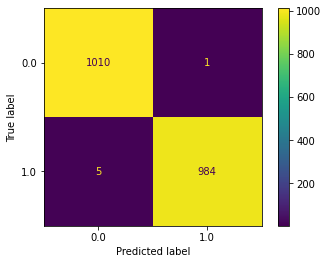

In [58]:
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
plot_confusion_matrix(svc, X_test, y_test)  
plt.show()

In [59]:
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
t=time.time()
knn.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train Knn...')

0.31 Seconds to train Knn...


Test Accuracy of Knn =  0.9285


C:\Users\ANUHYA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


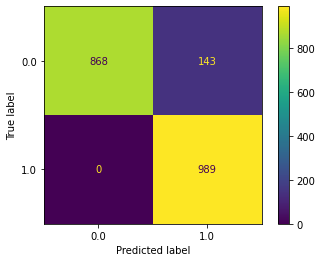

In [60]:
print('Test Accuracy of Knn = ', round(knn.score(X_test, y_test), 4))
plot_confusion_matrix(knn, X_test, y_test)  
plt.show()

In [61]:
polysvc = SVC(kernel='poly', degree = 2, random_state = 0)
t=time.time()
polysvc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train Poly svc...')

238.19 Seconds to train Poly svc...


Test Accuracy of Quadratic SVC =  0.998


C:\Users\ANUHYA\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


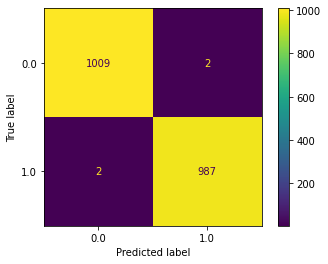

In [62]:
print('Test Accuracy of Quadratic SVC = ', round(polysvc.score(X_test, y_test), 4))
plot_confusion_matrix(polysvc, X_test, y_test)  
plt.show()

Visualizing HOG features

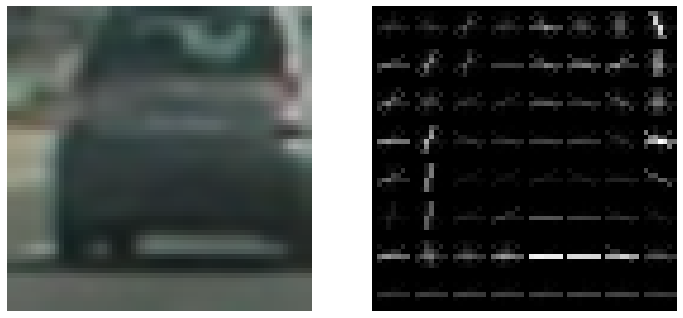

In [63]:
example_image = np.asarray(PIL.Image.open(cars[50]))
hog_features,visualized = get_hog_features(example_image, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,2,1)
plt.imshow(example_image)
plt.axis("off")
fig.add_subplot(1,2,2)
plt.imshow(visualized,cmap="gray")
plt.axis("off")
plt.show()

In [64]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #plt.figure()
    #plt.imshow(draw_img)
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int32(imshape[1]/scale), np.int32(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
    
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int32(xleft*scale)
                ytop_draw = np.int32(ytop*scale)
                win_draw = np.int32(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return bboxes


Visualising the results

For the image size 720x1280

(6, 4)


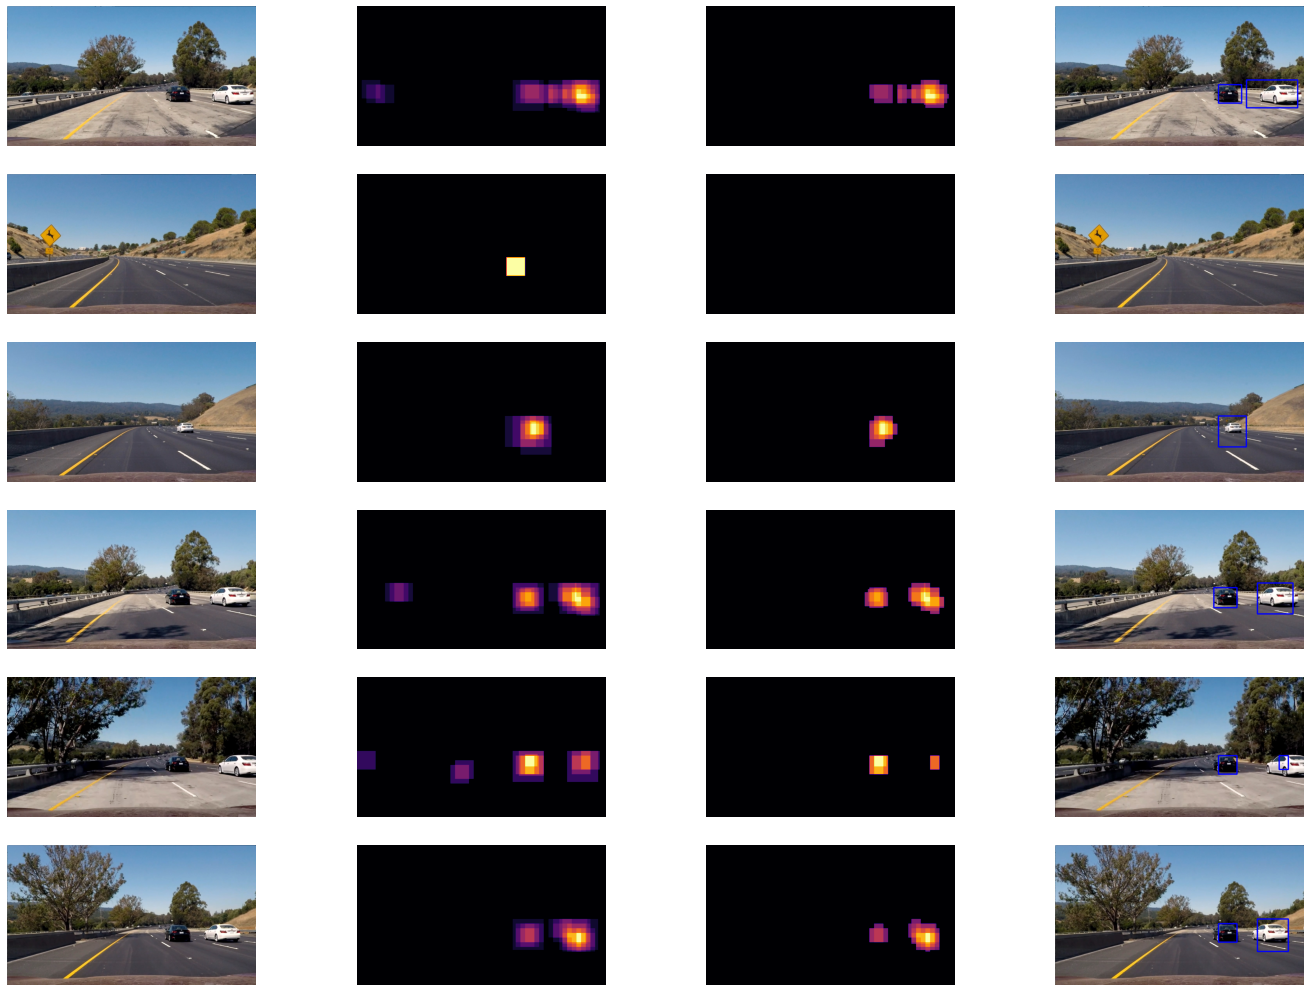

In [65]:
from scipy.ndimage.measurements import label
test_imgs = glob.glob('dataset/test_images/size1/*.jpg')
nrows = len(test_imgs)
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows))
y_range = {1.0 : (380,508), 
           1.5 : (380,572), 
           2.0 : (380,636), 
           2.5 : (380,700)} 
'''
y_range = {1.0 : (405,510), 
           1.5 : (400,600), 
           2.0 : (450,636), 
           2.5 : (500,710)} 
'''

for ax in axes.flatten():
    ax.axis('off')
print(axes.shape)
for image, ax in zip(test_imgs, axes):
    img = cv2.imread(image)
    out_img = np.copy(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    heat = np.zeros_like(img[:,:,0])
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for scale, i_color in zip(y_range.keys(), np.linspace(0,1,4)) :
        ystart,ystop = y_range[scale]
        color = tuple(255*c for c in plt.cm.rainbow(i_color)[:3])
        bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
        out_img = draw_boxes(out_img, bbox_list,color)
        heat = add_heat(heat,bbox_list)
    ax[1].imshow(heat, cmap=plt.cm.inferno)
    heat = apply_threshold(heat,3)  
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), labels)
    ax[3].imshow(draw_img)
    ax[2].imshow(heat, cmap=plt.cm.inferno)
    

(513, 1024, 3)


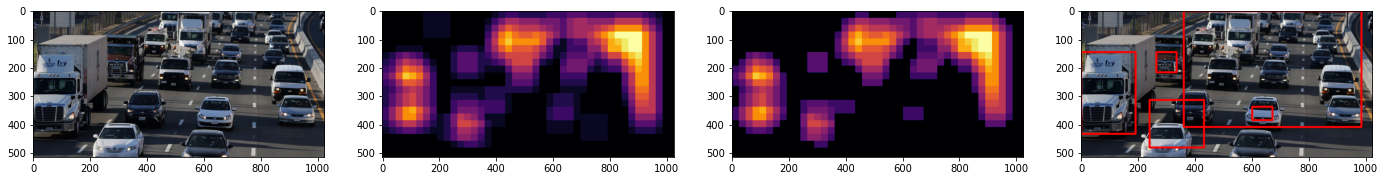

In [66]:
img_path='dataset/test_images/test9.jpg'

image=cv2.imread(img_path)
print(image.shape)
ystart = 0
ystop = image.shape[0]
scale = 1.5
fig = plt.figure(figsize=(24,12))

box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
heat = np.zeros_like(image[:,:,0])
heat = add_heat(heat,box_list)

plt.subplot(142)
plt.imshow(heat,cmap=plt.cm.inferno)
heat = apply_threshold(heat,2)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)


plt.subplot(141)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(143)
plt.imshow(heat,cmap=plt.cm.inferno)

plt.subplot(144)
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))

(500, 890, 3)


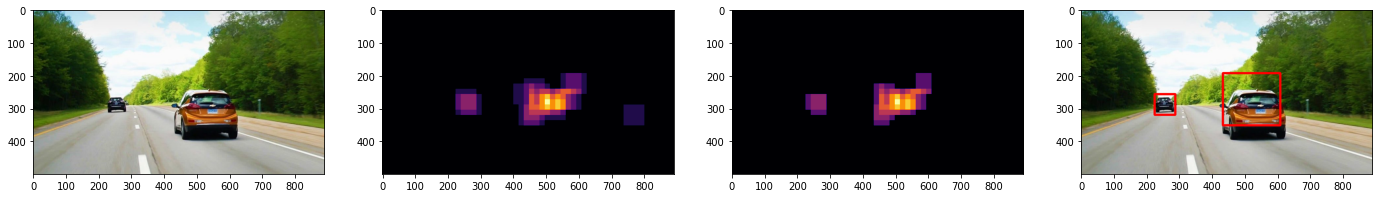

In [67]:
img_path='dataset/test_images/test14.jpg'

image=cv2.imread(img_path)
print(image.shape)
ystart = 0
ystop = image.shape[0]
scale = 1
fig = plt.figure(figsize=(24,12))

box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
heat = np.zeros_like(image[:,:,0])
heat = add_heat(heat,box_list)

plt.subplot(142)
plt.imshow(heat,cmap=plt.cm.inferno)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

plt.subplot(141)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(143)
plt.imshow(heat,cmap=plt.cm.inferno)

plt.subplot(144)
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))